Best Model: RandomForestRegressor()
R2: 0.9992598741212294
MSE: 0.06366546374999937
MAE: 0.16162565409053928
RMSE: 0.2523201612039739
Training set:
RMSE: 0.09264917710081842
R2: 0.9998885109942176
K-Fold Cross-Validation R-squared: 0.999171649975189
K-Fold Cross-Validation Standard Deviation: 0.0002016424349103116
Prediction Difference: [-4.15427948e-04  0.00000000e+00 -2.06077326e-04  5.64839844e-04
  5.22281684e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.27786680e-02  0.00000000e+00  0.00000000e+00  1.58397845e-03
 -6.75038118e-03  0.00000000e+00 -3.47542838e-03  0.00000000e+00
 -6.00388766e-03 -4.03381521e-04  3.91000415e-04 -2.04963810e-04
 -5.64345494e-03  0.00000000e+00  7.77198013e-03 -7.53575075e-04
  0.00000000e+00  0.00000000e+00 -3.53020574e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.20613161e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.71113065e-04
  0.0000000

<Figure size 1200x600 with 0 Axes>

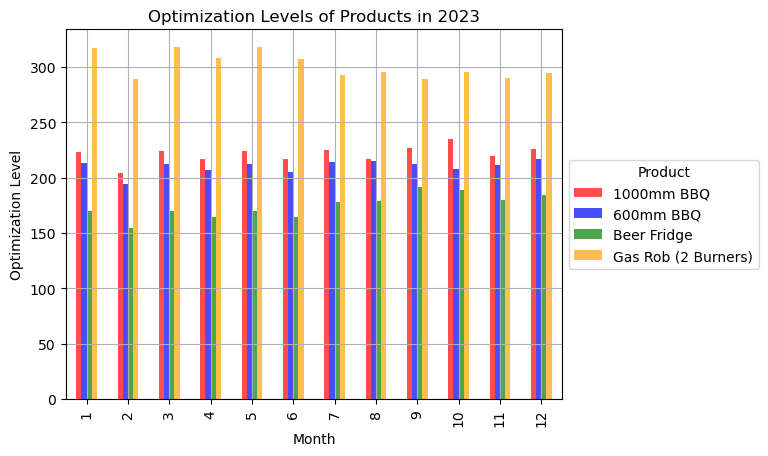

    month         product_type           0
0       1           1000mm BBQ  223.508443
1       1            600mm BBQ  212.940206
2       1          Beer Fridge  170.106965
3       1  Gas Rob (2 Burners)  317.221153
4       2           1000mm BBQ  203.742467
5       2            600mm BBQ  194.424387
6       2          Beer Fridge  154.821049
7       2  Gas Rob (2 Burners)  289.244691
8       3           1000mm BBQ  223.871308
9       3            600mm BBQ  212.103097
10      3          Beer Fridge  169.936386
11      3  Gas Rob (2 Burners)  317.510196
12      4           1000mm BBQ  216.399878
13      4            600mm BBQ  206.578760
14      4          Beer Fridge  164.311338
15      4  Gas Rob (2 Burners)  307.599116
16      5           1000mm BBQ  224.192531
17      5            600mm BBQ  212.612872
18      5          Beer Fridge  169.898377
19      5  Gas Rob (2 Burners)  317.960907
20      6           1000mm BBQ  216.712840
21      6            600mm BBQ  205.392641
22      6  

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv("/Users/skneuropa/Marlin Brands Dropbox/Luciano Souza/Programming/Cheat Sheets/ML Projects/ML inventory optimization/inventory_data.csv")

# Step 2: Extract the required columns into separate variables
d = df["demand_rate"]
L = df["lead_time"]
S = df["order_cost"]
C = df["unit_cost"]
H = 0.25 * C

# Step 3: Calculate the optimization level using the given formula
df["optimization_level"] = np.sqrt((2 * d * S) / (H * L))

# Step 4: Convert the 'date' column to datetime type and group the data monthly
df["date"] = pd.to_datetime(df["date"])
df_monthly = df.groupby([pd.Grouper(key="date", freq="M"), "product_type", "location"]).agg({
    "current_inventory": "sum",
    "demand_rate": "sum",
    "lead_time": "first",
    "order_cost": "first",
    "unit_cost": "first",
    "quantity_sold": "sum",
    "sales_price": "first",
    "total_sales": "sum",
    "optimization_level": "sum"
}).reset_index()

# Step 5: Extract the year and month from the 'date' column and drop the original 'date' column
df_monthly["year"] = df_monthly["date"].dt.year
df_monthly["month"] = df_monthly["date"].dt.month
df_monthly = df_monthly.drop("date", axis=1)

# Step 6: Encode categorical features using LabelEncoder
product_type_encoder = LabelEncoder()
location_encoder = LabelEncoder()

df_monthly["product_type_encoded"] = product_type_encoder.fit_transform(df_monthly["product_type"])
df_monthly["location_encoded"] = location_encoder.fit_transform(df_monthly["location"])

product_type_mapping = dict(zip(range(len(product_type_encoder.classes_)), product_type_encoder.classes_))
location_mapping = dict(zip(range(len(location_encoder.classes_)), location_encoder.classes_))

df_monthly.drop(["product_type", "location"], axis=1, inplace=True)

# Step 7: Prepare the input (X) and target (y) variables for model training
X = df_monthly.drop("optimization_level", axis=1)
y = df_monthly["optimization_level"]

# Step 8: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Define the models to be evaluated
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

# Step 10: Find the best model based on RMSE score on the test set
best_model = None
best_rmse = float("inf")

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if rmse < best_rmse:
        best_model = model
        best_rmse = rmse

# Step 11: Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best Model:", best_model)
print("R2:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)

# Additional Analysis:

# Step 12: Evaluate the best model on the training set
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print("Training set:")
print("RMSE:", train_rmse)
print("R2:", train_r2)

# Step 13: Perform k-fold cross-validation and calculate the mean and standard deviation of R-squared scores
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=kfold_cv, scoring='r2')
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"K-Fold Cross-Validation R-squared: {mean_cv_score}")
print(f"K-Fold Cross-Validation Standard Deviation: {std_cv_score}")

# Step 14: Perform sensitivity analysis by perturbing a specific feature and observe the prediction difference
sensitivity_data = X.sample(frac=0.1, random_state=42)
feature_to_perturb = "current_inventory"
perturbation = 0.01  # 1% perturbation
perturbed_data = sensitivity_data.copy()
perturbed_data[feature_to_perturb] *= (1 + perturbation)

predictions_original = best_model.predict(sensitivity_data)
predictions_perturbed = best_model.predict(perturbed_data)
prediction_diff = predictions_perturbed - predictions_original

print("Prediction Difference:", prediction_diff)

# Add the future months to the df for the predictions:

# Read the inventory data into a DataFrame
df = pd.read_csv("/Users/skneuropa/Marlin Brands Dropbox/Luciano Souza/Programming/Cheat Sheets/ML Projects/ML inventory optimization/inventory_data.csv")

# Calculate the optimization level for each row in the DataFrame
d = df["demand_rate"]
L = df["lead_time"]
S = df["order_cost"]
C = df["unit_cost"]
H = 0.25 * C
df["optimization_level"] = np.sqrt((2 * d * S) / (H * L))

# Define the months and years
months = ['07', '08', '09', '10', '11', '12']
years = ['2023']

# Create a list of all unique locations and product types from the original DataFrame
locations = df['location'].unique()
product_types = df['product_type'].unique()

# Create an empty list to store the new rows
new_rows = []

# Iterate over the combinations of location and product type
for location in locations:
    for product_type in product_types:
        # Get the last current inventory and demand rate for the combination
        last_inventory = df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'current_inventory'].iloc[-1]
        last_demand_rate = df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'demand_rate'].iloc[-1]

        # Calculate the average quantity sold for the same period in 2022
        avg_quantity_sold = df.loc[(df['date'].str.startswith('2022')) & (df['location'] == location) & (df['product_type'] == product_type), 'quantity_sold'].mean()

        # Create new rows for each month and year combination
        for year in years:
            for month in months:
                date = f"{year}-{month}-01"
                new_row = {
                    'date': pd.to_datetime(date),
                    'location': location,
                    'product_type': product_type,
                    'current_inventory': int(last_inventory),
                    'demand_rate': float(last_demand_rate),
                    'lead_time': int(df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'lead_time'].iloc[0]),
                    'order_cost': float(df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'order_cost'].iloc[0]),
                    'unit_cost': float(df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'unit_cost'].iloc[0]),
                    'quantity_sold': float(avg_quantity_sold),
                    'sales_price': float(df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'sales_price'].iloc[0]),
                    'total_sales': float(avg_quantity_sold) * float(df.loc[(df['location'] == location) & (df['product_type'] == product_type), 'sales_price'].iloc[0]),
                    'optimization_level': 0
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
new_df = pd.DataFrame(new_rows)

# Concatenate the original DataFrame with the new DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Convert the 'date' column to datetime type
df["date"] = pd.to_datetime(df["date"])

# Group the data monthly by product_type, location, and date
df_monthly = df.groupby([pd.Grouper(key="date", freq="M"), "product_type", "location"]).agg({
    "current_inventory": "sum",
    "demand_rate": "sum",
    "lead_time": "first",
    "order_cost": "first",
    "unit_cost": "first",
    "quantity_sold": "sum",
    "sales_price": "first",
    "total_sales": "sum",
    "optimization_level": "sum"
}).reset_index()

# Extract the year and month from the date
df_monthly["year"] = df_monthly["date"].dt.year
df_monthly["month"] = df_monthly["date"].dt.month

# Drop the 'date' column
df_monthly = df_monthly.drop("date", axis=1)

# Create separate label encoders for product_type and location
product_type_encoder = LabelEncoder()
location_encoder = LabelEncoder()

# Encode the product_type and location columns
df_monthly["product_type_encoded"] = product_type_encoder.fit_transform(df_monthly["product_type"])
df_monthly["location_encoded"] = location_encoder.fit_transform(df_monthly["location"])

# Create mapping dictionaries for product_type and location
product_type_mapping = dict(zip(range(len(product_type_encoder.classes_)), product_type_encoder.classes_))
location_mapping = dict(zip(range(len(location_encoder.classes_)), location_encoder.classes_))

# Drop the original product_type and location columns
df_monthly.drop(["product_type", "location"], axis=1, inplace=True)

# Split the data into input features (X) and target variable (y)
X = df_monthly.drop("optimization_level", axis=1)
y = df_monthly["optimization_level"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate predictions using the best_model
y_pred = best_model.predict(X_test)

# Filter the rows based on the desired year and month range
year_filter = 2023
start_month = 7
end_month = 12
filter_condition = (df_monthly['year'] == year_filter) & (df_monthly['month'].between(start_month, end_month))
filtered_rows = df_monthly.loc[filter_condition].copy()

# Assign the predicted values to the optimization_level column in the filtered rows
filtered_rows['optimization_level'] = y_pred[:len(filtered_rows)]

# Update the corresponding rows in the original df_monthly DataFrame
df_monthly.loc[filter_condition] = filtered_rows

# Reverse the encoding for product_type
df_monthly['product_type'] = df_monthly['product_type_encoded'].map(product_type_mapping)

# Reverse the encoding for location
df_monthly['location'] = df_monthly['location_encoded'].map(location_mapping)

# Drop the encoded columns
df_monthly.drop(['product_type_encoded', 'location_encoded'], axis=1, inplace=True)

# Group the DataFrame by 'product_type', 'year', and 'location' columns and calculate the sum of 'optimization_level'
total_optimization = df_monthly.groupby(['product_type', 'year', 'location'])['optimization_level'].sum().unstack(level='year').reset_index()
df_monthly.head(20)

# Plots:

import matplotlib.pyplot as plt

# Pivot the data to create separate columns for each product
pivot_df = df_monthly.pivot_table(index='month', columns=['product_type', 'location'], values='optimization_level')

# Sum the optimization levels across locations for each product
pivot_df = pivot_df.groupby(level='product_type', axis=1).sum()

# Define the colors for each product type
colors = ['red', 'blue', 'green', 'orange']

# Plot the data
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', color=colors, alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Optimization Level')
plt.title('Optimization Levels of Products in 2023')
plt.legend(title='Product', loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside the plot
plt.grid(True)
plt.show()

# Print the data being plotted
data_table = pivot_df.stack(level='product_type').reset_index().rename_axis(None, axis=1)
print(data_table)

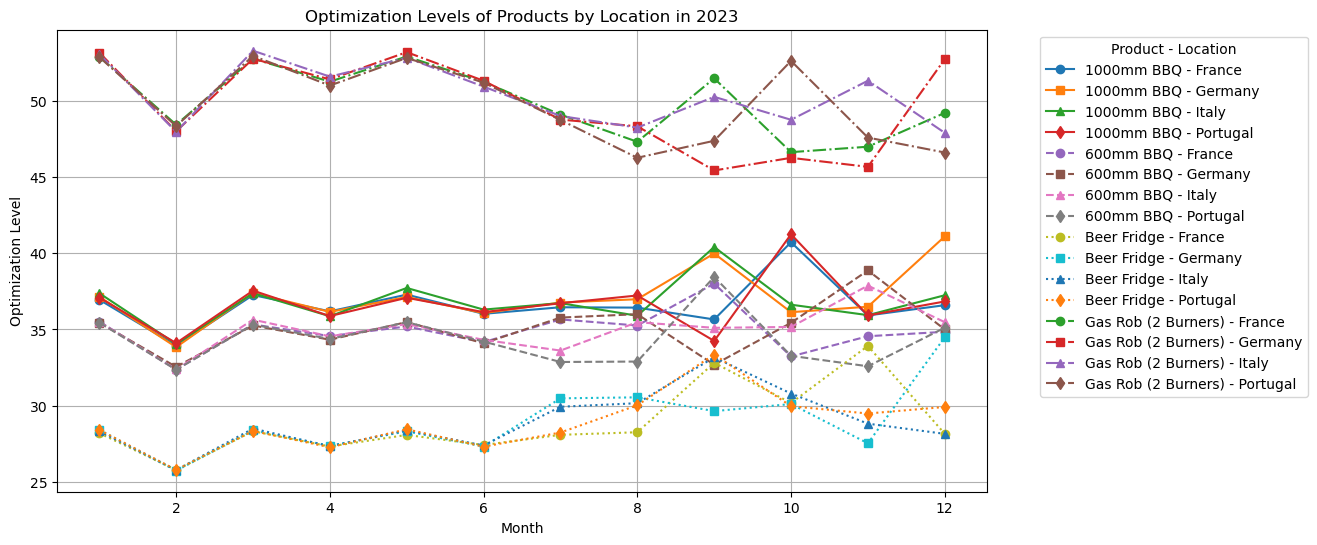

       product_type location  Optimization Level Month
         1000mm BBQ   France           36.954199   Jan
         1000mm BBQ  Germany           37.147954   Jan
         1000mm BBQ    Italy           37.379511   Jan
         1000mm BBQ Portugal           37.093366   Jan
         1000mm BBQ    Spain           37.515549   Jan
         1000mm BBQ       UK           37.417865   Jan
          600mm BBQ   France           35.521696   Jan
          600mm BBQ  Germany           35.448926   Jan
          600mm BBQ    Italy           35.484320   Jan
          600mm BBQ Portugal           35.455915   Jan
          600mm BBQ    Spain           35.493492   Jan
          600mm BBQ       UK           35.535858   Jan
        Beer Fridge   France           28.196817   Jan
        Beer Fridge  Germany           28.416168   Jan
        Beer Fridge    Italy           28.312412   Jan
        Beer Fridge Portugal           28.408846   Jan
        Beer Fridge    Spain           28.370555   Jan
        Be

In [2]:
import calendar
# Pivot the data to create separate columns for each product and location combination
pivot_df = df_monthly.pivot_table(index='month', columns=['product_type', 'location'], values='optimization_level')

# Define distinct line styles for each product
product_line_styles = ['-', '--', ':', '-.']  # Example line styles for products

# Define distinct marker styles for each location
location_marker_styles = ['o', 's', '^', 'd']  # Example marker styles for locations

# Plot the data
plt.figure(figsize=(12, 6))

# Iterate over each product type
for product_type, line_style in zip(pivot_df.columns.get_level_values('product_type').unique(), product_line_styles):
    # Iterate over each location within the product
    for location, marker_style in zip(pivot_df[product_type].columns, location_marker_styles):
        # Plot the optimization levels for each product-location combination
        plt.plot(pivot_df.index, pivot_df[product_type][location], label=f'{product_type} - {location}', linestyle=line_style, marker=marker_style)

plt.xlabel('Month')
plt.ylabel('Optimization Level')
plt.title('Optimization Levels of Products by Location in 2023')
plt.legend(title='Product - Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Print the data being plotted
data_table = pivot_df.stack(level=['product_type', 'location']).reset_index().rename_axis(None, axis=1)
data_table.rename(columns={0: 'Optimization Level'}, inplace=True)  # Rename the optimization level column
data_table['Month'] = data_table['month'].apply(lambda x: calendar.month_abbr[x])  # Convert month numbers to abbreviations
data_table.drop('month', axis=1, inplace=True)  # Remove the original month column

# Set the display options for pandas to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(data_table.to_string(index=False))